# Clustering

In [1]:
%load_ext autoreload
%autoreload 2

## Get Spotify Tracks

In [2]:
import tekore as tk
from smoothify.features import construct_features
import numpy as np

### Obtaining an API Access Token

You'll need an access token to call the Spotify API.

Here's how to get a temporary token to play around with (expires in ~30 mins):

- Visit https://developer.spotify.com/console/get-playlist-tracks/
- Click 'Get Token'
- Select the following permissions:
    - `user-library-read`
    - `playlist-read-private`
    - `playlist-read-collaborative`
    - `playlist-modify-public`
    - `playlist-modify-private`
- Click 'Request Token'
- Copy the text in the 'OAuth Token' field

Paste the access token below

In [3]:
ACCESS_TOKEN = "BQDwNOmgA6-Wb5pd1QY2syoXNRjg1bBCdtE8NJlb6ZSb-SmkNCne9tq-uwqf-abQlZVcZd2gWqxAV9HoOf13DONpxje-dkZz6MvZDgZtepwOI_awyzirw7ChmWfxH9B_BfRtwJepGEhcFtpakliogxP2YgHESuPLlpyOHpNeneaAjPzsOJH2LuIMrtpNOReNORaT304b6EoW2eypCHoAERl0oyBIa6NzpeG_cPoPL-QxzLPe7qw"
spotify = tk.Spotify(ACCESS_TOKEN, asynchronous=True, max_limits_on=True, chunked_on=True)
current_user = await spotify.current_user()

### Fetch tracks from current user's Liked Songs

In [4]:
saved_tracks_page = await spotify.saved_tracks()
track_list = [track.track async for track in spotify.all_items(saved_tracks_page)]
playlist_name = f"{current_user.display_name}'s Library"
is_playlist_public = False
is_playlist_collaborative = False
print(f"Fetched {len(track_list)} tracks")

Fetched 531 tracks


### Fetch tracks from a playlist

To read the tracks in a playlist, you'll need the playlist's ID.

You can find a playlist's ID in its URL, which looks like `https://open.spotify.com/playlist/{playlist_id}`

#### Getting a Playlist's URL

- Navigate to your playlist
- Under the playlist's title, click the triple-dot icon and select to `Share -> Copy link to playlist`


In [61]:
PLAYLIST_ID = "5jmnLc4tTk8Wbig6TP17p1"
playlist = await spotify.playlist(PLAYLIST_ID)
track_list = [track.track async for track in spotify.all_items(playlist.tracks)]
playlist_name = playlist.name
is_playlist_public = playlist.public
is_playlist_collaborative = playlist.collaborative
print(f"Fetched {len(track_list)} tracks")

Fetched 444 tracks


## Construct audio features

### Query Spotify API for audio features

In [5]:
# Extract track IDs so we can fetch additional info
track_id_list = [track.id for track in track_list]
# Get track audio features
track_features_list = await spotify.tracks_audio_features(track_id_list)

### Merge & normalize features

In [6]:
features_df = construct_features(audio_features_list=track_features_list)
features_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.526728,-0.558664,-0.349908,0.130886,-0.678244,-0.738907,-0.702520,1.075576,-0.019850
1,-0.270316,1.331587,0.874591,0.340775,-0.564689,-0.784524,-0.357060,1.306981,0.268654
2,0.836608,0.242758,0.155296,-0.756161,-0.296462,-0.784524,1.909257,0.596806,0.184870
3,0.440302,1.187884,0.869561,1.564870,-0.644971,-0.784497,1.063982,0.405299,0.104714
4,0.993764,-0.354163,0.046521,-0.474267,-0.070465,-0.515523,-0.516315,-1.098835,-0.020427


In [7]:
points = np.array(features_df)

## Cluster & Visualize

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

### T-SNE Dimensionality Reduction

In [9]:
from sklearn.manifold import TSNE
reducer = TSNE(learning_rate="auto", init="pca")
projection = reducer.fit_transform(points)

/home/krishna/.pyenv/versions/3.9.9/envs/smoothify/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


### HDBSCAN Clustering

In [10]:
from hdbscan import HDBSCAN

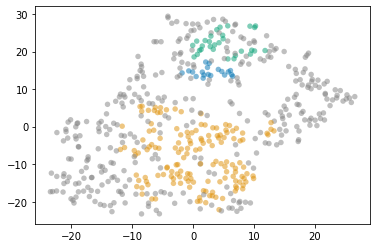

In [11]:
clusterer = HDBSCAN(min_cluster_size=10, min_samples=2)
clusters = clusterer.fit(points)

color_palette = sns.color_palette('colorblind', 10)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusters.labels_]
plt.scatter(*projection.T, s=30, linewidth=0, c=cluster_colors, alpha=0.5)

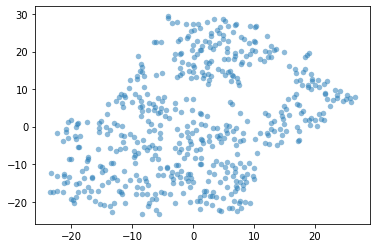

In [12]:
clusterer = HDBSCAN(min_cluster_size=10, min_samples=2)
clusters = clusterer.fit(projection)

color_palette = sns.color_palette('colorblind', 10)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusters.labels_]
plt.scatter(*projection.T, s=30, linewidth=0, c=cluster_colors, alpha=0.5)

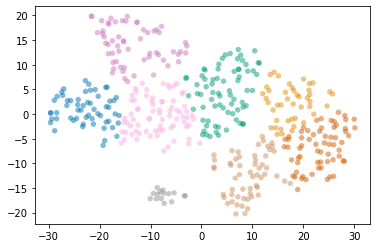

In [191]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=len(projection) // 50)
clusters = clusterer.fit(projection)

color_palette = sns.color_palette('colorblind', 10)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusters.labels_]
plt.scatter(*projection.T, s=30, linewidth=0, c=cluster_colors, alpha=0.5)